In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import glob
import numpy as np
import time
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")
scaler = preprocessing.MinMaxScaler()
LIM=10
PATH = "./../out/uniprot_sprot.40.multi-step/"

In [2]:
def time_ms():
    return round(time.time()*1000)

def clean_column_ids(df, col):
    return df[col].map(lambda x: x.split("|")[1])

def parse_fasta(protein_fasta):
    id = protein_fasta.split("\n")[0]
    sequence = ''.join(protein_fasta.split("\n")[1:])
    return (id, sequence)



In [28]:
def read_score(path):
    df = pd.read_csv(path,   delimiter=r"\s+", comment="#", usecols=[0,2,4,5,6], header=None)
    df.columns = ["sequence", "reference", "eval", "score", "bias"]
    df.sort_values(by=["score"], inplace=True, ascending=False)
    df["sequence"] = clean_column_ids(df, "sequence")
    df.set_index("sequence", inplace=True)
    return df
def read_identity(path, ref):
    df = pd.read_csv(path,   delimiter=r"\s+", comment="#", usecols=[0,1,2,3,4], header=None)
    df.columns = ["seq1", "seq2", "identity", "nid", "denom"]
    idx1 = df["seq1"].str.contains(ref)
    idx2 = df["seq2"].str.contains(ref)
    df = df[idx1 | idx2]
    idx = (df["seq2"].str.contains(ref))
    # put all references to the seq2 column
    df.loc[idx, ["seq1", "seq2"]] = df.loc[idx, ["seq2", "seq1"]].values
    df["seq2"] = df["seq2"].map(lambda x: x.split("|")[1])
    return df.drop(columns=["seq1"]).set_index("seq2")
def read_family(path):
    df = None
    try:
        df = pd.read_csv(path, delimiter=r"\s+", comment="#", usecols=[0,2,4,5,6], header=None)
    except pd.errors.EmptyDataError:
        return pd.DataFrame(columns=["family", "seq", "f_eval", "f_score", "f_bias"])
    df.columns = ["family", "seq", "f_eval", "f_score", "f_bias"]
    df["seq"] = clean_column_ids(df, "seq")
    #df.drop_duplicates(subset=["seq"], keep="first", inplace=True)
    df.set_index("seq", inplace=True)
    return df
def read_len(path):
    db_fasta = ""
    with open(path, "r") as f:
        db_fasta = ("\n" + f.read()).split("\n>")[1:]
    a = []
    for protein_fasta in db_fasta:
        id, seq = parse_fasta(protein_fasta)
        id = id.split("|")[1]
        a.append((id, len(seq)))
    return pd.DataFrame(a, columns=["seq", "seqlen"]).set_index("seq").rename_axis(index=None)
    

In [4]:
def load_all(path, normalise=True, lim=LIM):
    id_files = sorted(glob.glob(path.replace("$$$", "id")))
    hmms_files = sorted(glob.glob(path.replace("$$$", "hmmsearch")))
    phmm_files = sorted(glob.glob(path.replace("$$$", "phmmer")))
    fam_files = sorted(glob.glob(path.replace("$$$", "hmmscan")))
    fasta_files = sorted(glob.glob(path.replace("$$$", "clean").replace(".out", ".clean.fasta")))
    dfs = []
    files = list(zip(hmms_files, phmm_files, id_files, fam_files, fasta_files))
    for file in files[:lim]:
        ref = file[0].split("/")[-1].split(".")[0]
        hmms_df = read_score(file[0]).rename(columns={"score" : "hmms_score", "eval" : "hmms_eval", "bias" : "hmms_bias"})
        phmm_df = read_score(file[1]).rename(columns={"score" : "phmm_score", "eval" : "phmm_eval", "bias" : "phmm_bias"})
        phmm_df.drop(["reference"], axis=1, inplace=True)
        id_df = read_identity(file[2], ref)
        fam_df = read_family(file[3])
        len_df = read_len(file[4])
        df = pd.concat([phmm_df, hmms_df, id_df, len_df], axis=1)
        df = df.join(fam_df)
        if normalise:
            df["phmm_score"] = scaler.fit_transform(df["phmm_score"].values.reshape(-1,1))
            df["hmms_score"] = scaler.fit_transform(df["hmms_score"].values.reshape(-1,1))
        dfs.append(df)
    frame = pd.concat(dfs, axis=0)
    return frame


In [5]:
data = load_all(PATH + "$$$/*.out", lim=10, normalise=False)

In [6]:
def splot(df, x, y, hue=None, legend=True, ylog=False):
    f, ax = plt.subplots(figsize=(6.5,6.5))
    sb.set_theme(style="whitegrid")
    if ylog:
        ax.set(yscale="log")
    sb.scatterplot(x=x, y=y, hue=hue, ax=ax, data=df)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    if ax.get_legend() and not legend:
        ax.get_legend().remove()

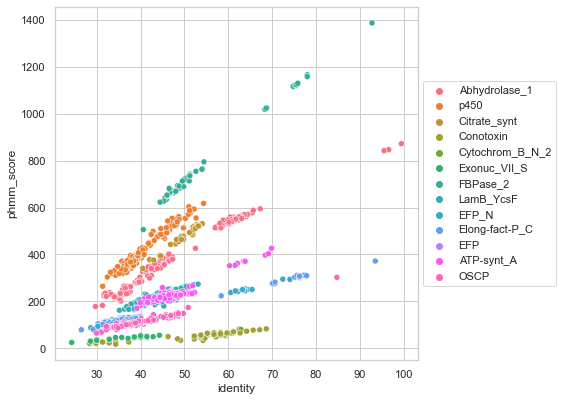

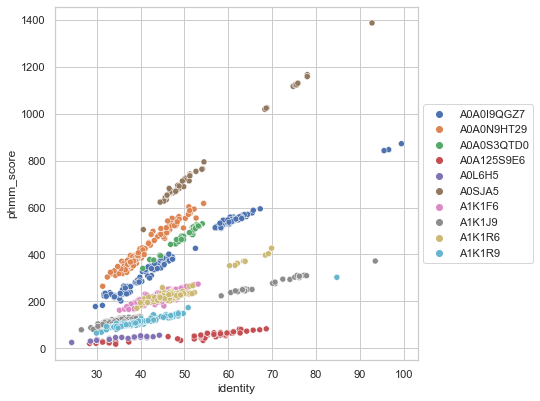

In [66]:
temp = data.reset_index().drop_duplicates(subset="index", keep="first").set_index("index")
splot(temp, "identity", "phmm_score", hue="family")
splot(temp, "identity", "phmm_score", hue="reference")

- Phmmer vs. identity relationship quite linear
- One color represents one PFAM domain/cluster
- Usually, one cluster has one PFAM domain


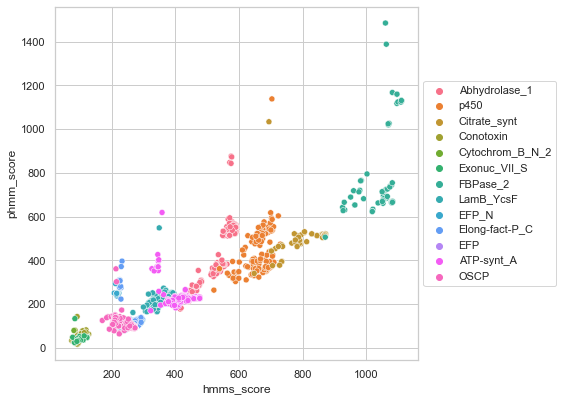

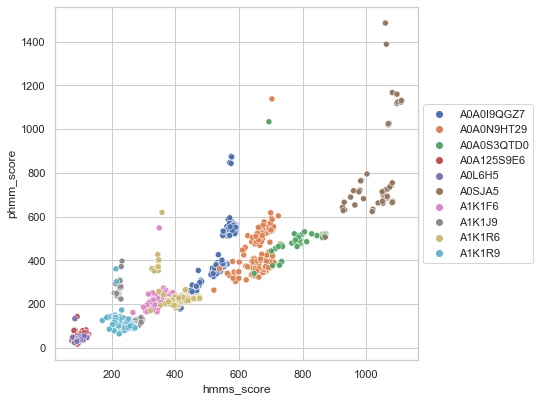

In [68]:
splot(temp, "hmms_score", "phmm_score", hue="family")
splot(temp, "hmms_score", "phmm_score", hue="reference")

- Relationship between phmmer (cluster vs. reference) and hmmsearch (cluster vs. MSA) score
- 10 different clusters, one color represents one PFAM domain/cluster
- Most clusters have a linear relationship between these two variables
- No apparent behavioral similarity between two different clusters

In [23]:
data.corr(method="pearson").style.background_gradient(cmap="coolwarm").set_precision(2)


,phmm_eval,phmm_score,phmm_bias,hmms_eval,hmms_score,hmms_bias,identity,nid,denom,seqlen,f_eval,f_score
phmm_eval,1.00,-0.03,-0.01,-0.00,-0.03,-0.00,-0.02,-0.03,-0.04,-0.04,0.00,-0.01
phmm_score,-0.03,1.00,0.24,-0.02,0.91,0.08,0.74,0.99,0.89,0.89,-0.02,0.31
phmm_bias,-0.01,0.24,1.00,0.00,0.29,0.84,0.33,0.30,0.23,0.22,0.21,0.21
hmms_eval,-0.00,-0.02,0.00,1.00,-0.03,0.01,0.01,-0.02,-0.03,-0.03,-0.00,-0.01
hmms_score,-0.03,0.91,0.29,-0.03,1.00,0.11,0.52,0.94,0.97,0.97,-0.00,0.38
hmms_bias,-0.00,0.08,0.84,0.01,0.11,1.00,0.15,0.11,0.02,0.02,0.24,0.12
identity,-0.02,0.74,0.33,0.01,0.52,0.15,1.00,0.73,0.47,0.47,0.00,0.13
nid,-0.03,0.99,0.30,-0.02,0.94,0.11,0.73,1.00,0.92,0.92,-0.01,0.33
denom,-0.04,0.89,0.23,-0.03,0.97,0.02,0.47,0.92,1.00,1.00,-0.01,0.36
seqlen,-0.04,0.89,0.22,-0.03,0.97,0.02,0.47,0.92,1.00,1.00,-0.01,0.36


- Correlation matrix
- Linear correlation between all variables
- nid: number of identical aligned pairs
- denom: denominator used for the calculation: the shorter of the two (unaligned) sequence lengths.
- f_score: family score
- f_eval: family e-value

In [10]:
data.corr(method="spearman").style.background_gradient(cmap="coolwarm").set_precision(2)

,phmm_eval,phmm_score,phmm_bias,hmms_eval,hmms_score,hmms_bias,identity,nid,denom,seqlen,f_eval,f_score
phmm_eval,1.00,-1.00,-0.03,0.86,-0.86,0.31,-0.77,-0.98,-0.90,-0.86,0.05,-0.04
phmm_score,-1.00,1.00,0.03,-0.86,0.86,-0.32,0.77,0.98,0.90,0.86,-0.05,0.04
phmm_bias,-0.03,0.03,1.00,0.07,-0.07,0.74,0.31,0.07,-0.06,-0.09,0.08,-0.07
hmms_eval,0.86,-0.86,0.07,1.00,-1.00,0.32,-0.56,-0.86,-0.93,-0.89,0.08,-0.08
hmms_score,-0.86,0.86,-0.07,-1.00,1.00,-0.33,0.56,0.87,0.93,0.89,-0.08,0.08
hmms_bias,0.31,-0.32,0.74,0.32,-0.33,1.00,-0.00,-0.28,-0.36,-0.40,0.09,-0.08
identity,-0.77,0.77,0.31,-0.56,0.56,-0.00,1.00,0.80,0.55,0.52,0.02,-0.02
nid,-0.98,0.98,0.07,-0.86,0.87,-0.28,0.80,1.00,0.89,0.85,-0.04,0.04
denom,-0.90,0.90,-0.06,-0.93,0.93,-0.36,0.55,0.89,1.00,0.97,-0.06,0.06
seqlen,-0.86,0.86,-0.09,-0.89,0.89,-0.40,0.52,0.85,0.97,1.00,-0.06,0.06


- Monotonic correlation
- nid: number of identical aligned pairs
- denom: denominator used for the calculation: the shorter of the two (unaligned) sequence lengths.
- f_score: family score
- f_eval: family e-value

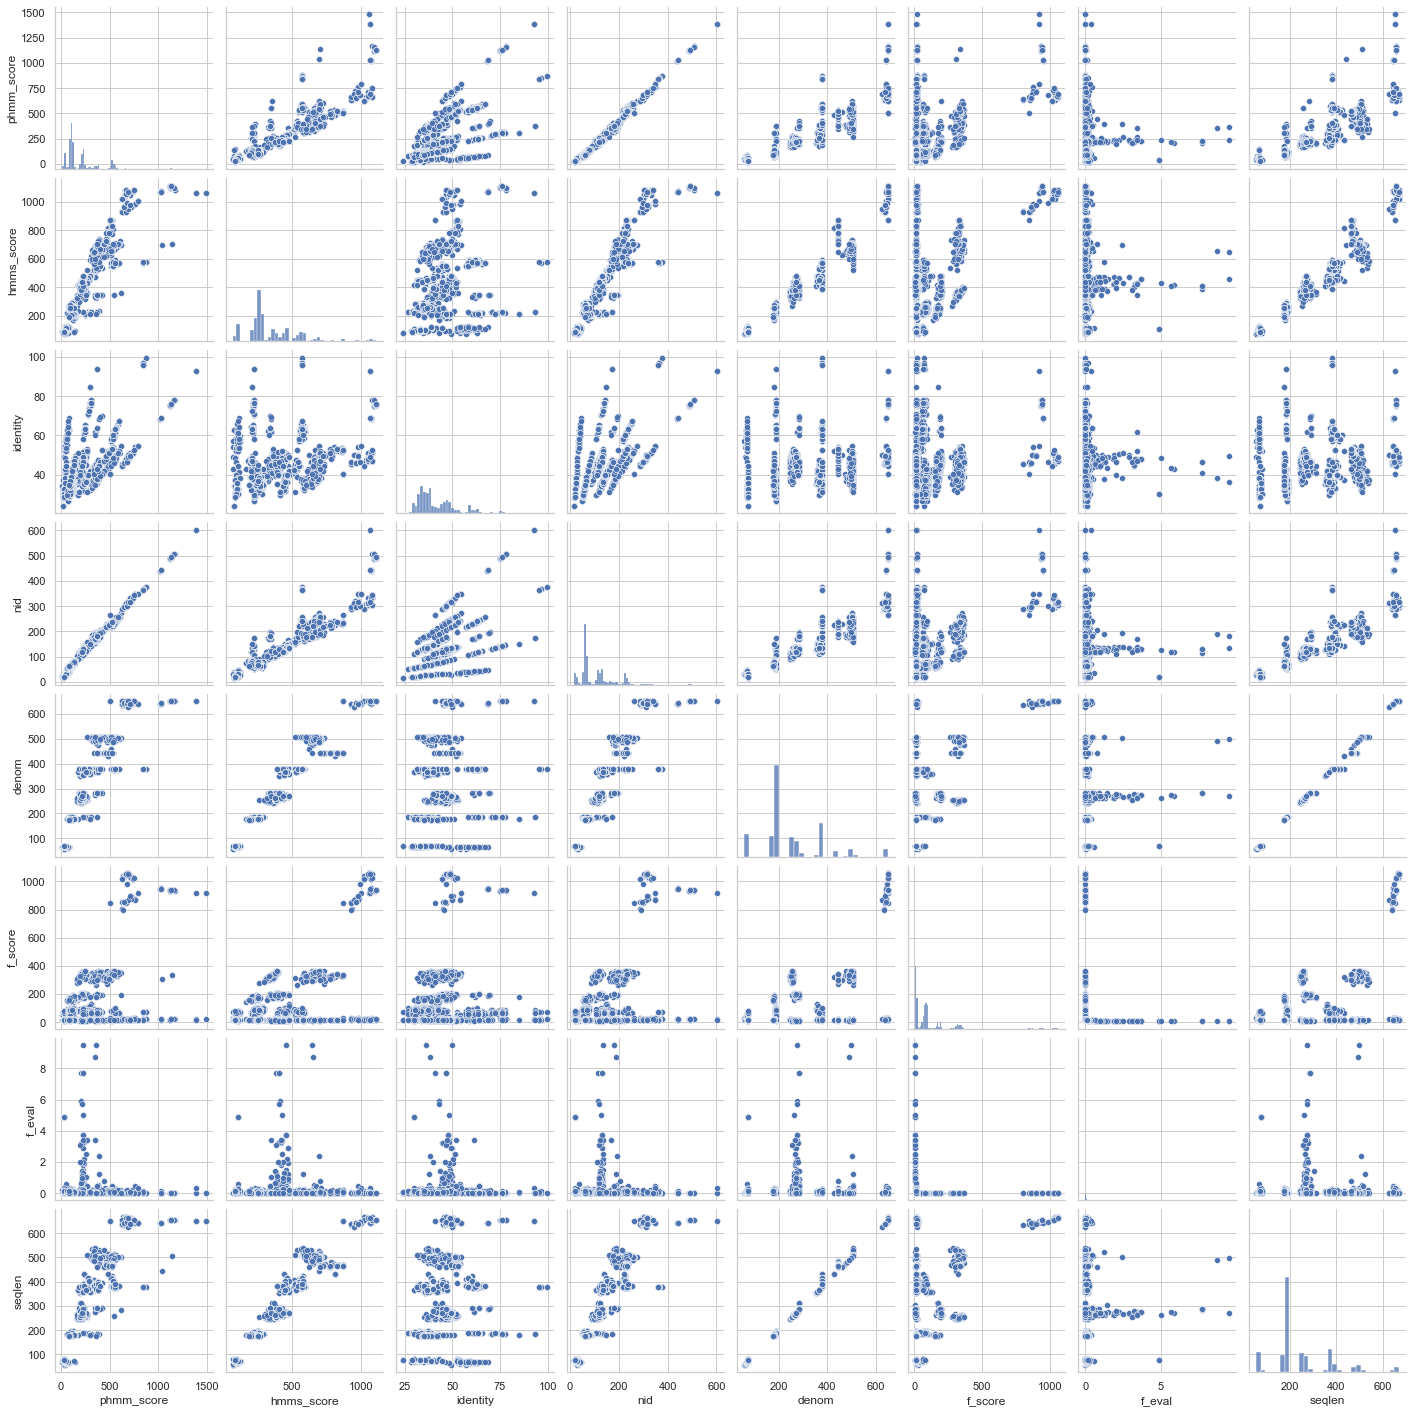

In [11]:
sb.pairplot(data[["phmm_score", "hmms_score", "identity", "nid", "denom", "f_score", "f_eval", "seqlen"]])

In [12]:
def ith_fam(df, i, use_none=False):
    m = {}
    for seq in df.groupby("seq"):
        if use_none and len(seq[1]["family"]) <= i:
            m[seq[0]] = "none"
        else:
            m[seq[0]] = seq[1]["family"].iloc[min(i, len(seq[1]["family"])-1)]
    return m

def get_id(id_map, i, j):
    if i == j:
        return 100
    return id_map[i + j] if i + j in id_map.keys() else id_map[j + i]

def set_map(m, r):
    m[r["seq1"] + r["seq2"]] = r["identity"]

def get_id_map(df):
    m = {}
    df.apply(lambda row: set_map(m, row), axis=1)
    return m


def cluster_matrix(path, fam_i1, fam_i2):
    ids = pd.read_csv(path.replace("$$$", "id"),   delimiter=r"\s+", comment="#", usecols=[0,1,2,3,4], header=None)
    ids.columns = ["seq1", "seq2", "identity", "nid", "denom"]
    ids["seq1"] = clean_column_ids(ids, "seq1")
    ids["seq2"] = clean_column_ids(ids, "seq2")
    id_map = get_id_map(ids)
    fams = pd.read_csv(path.replace("$$$", "hmmscan"), delimiter=r"\s+", comment="#", usecols=[0,2,4,5], header=None)
    fams.columns = ["family", "seq", "eval", "score"]
    fams["seq"] = clean_column_ids(fams, "seq")
    fd1 = ith_fam(fams, fam_i1, True)
    fd2 = ith_fam(fams, fam_i2, True)
    seqs = np.unique(pd.unique(ids["seq1"]).tolist() + pd.unique(ids["seq2"]).tolist()).tolist()
    row_idx = pd.MultiIndex.from_tuples([(k, v) for k, v in fd1.items()], names=["seq", "family1"])
    col_idx = pd.MultiIndex.from_tuples([(k, v) for k, v in fd2.items()], names=["seq", "family2"])
    temp = [[get_id(id_map, x, y) for x in seqs] for y in seqs]
    identity_matrix = pd.DataFrame(temp, index=row_idx, columns=col_idx)
    return identity_matrix

def get_fam_color(df, name, idx):
    distinct_fam_count = np.unique(idx.get_level_values(name).values).shape[0]
    used_networks = list(np.unique(idx.get_level_values(name).values))
    network_pal = sb.husl_palette(distinct_fam_count, s=.85)
    network_lut = dict(zip(map(str, used_networks), network_pal))
    network_lut["none"] = (1,1,1)
    networks = idx.get_level_values(name)
    return pd.Series(networks, index=idx).map(network_lut)

def cluster_plot(cluster_matrix, w=0):
    sb.clustermap(cluster_matrix, center=0, cmap="vlag", row_colors=get_fam_color(cluster_matrix, "family1", cluster_matrix.index), col_colors=get_fam_color(cluster_matrix, "family2", cluster_matrix.columns), dendrogram_ratio=(.1, .2), cbar_pos=(0,0,0.05,0.15), linewidths=w, figsize=(12, 13))

In [13]:
id_matrix = cluster_matrix("./../out/uniprot_sprot.40.multi-step/$$$/A4G9H5.out", 1,2)

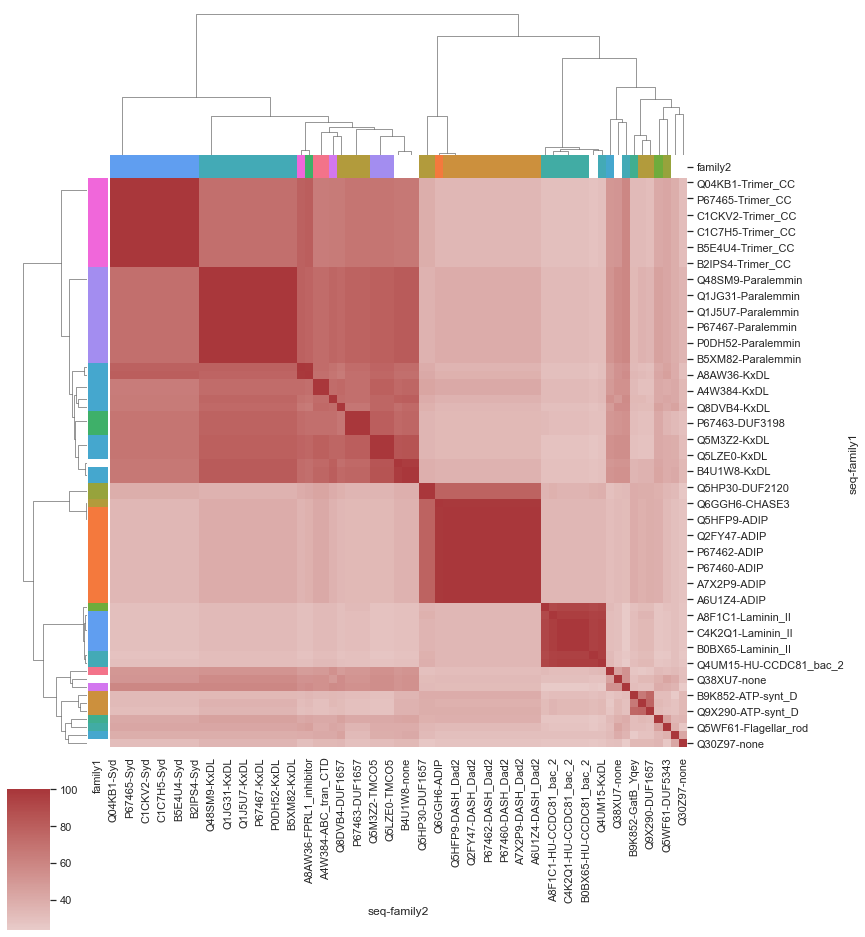

In [14]:
cluster_plot(cluster_matrix("./../out/uniprot_sprot.40.multi-step/$$$/A0L6H5.out", 1,2), 0)

- Cluster matrix: each sequence compared to every other sequence in the cluster
- Left-most column: each color represents PFAM domain that got the best score for the sequence
- Top row: each color represents PFAM domain that got the second best score for the sequence
- Clear patterns between different PFAM domains
- White family color -> no PFAM domain fit the treshhold for that sequence

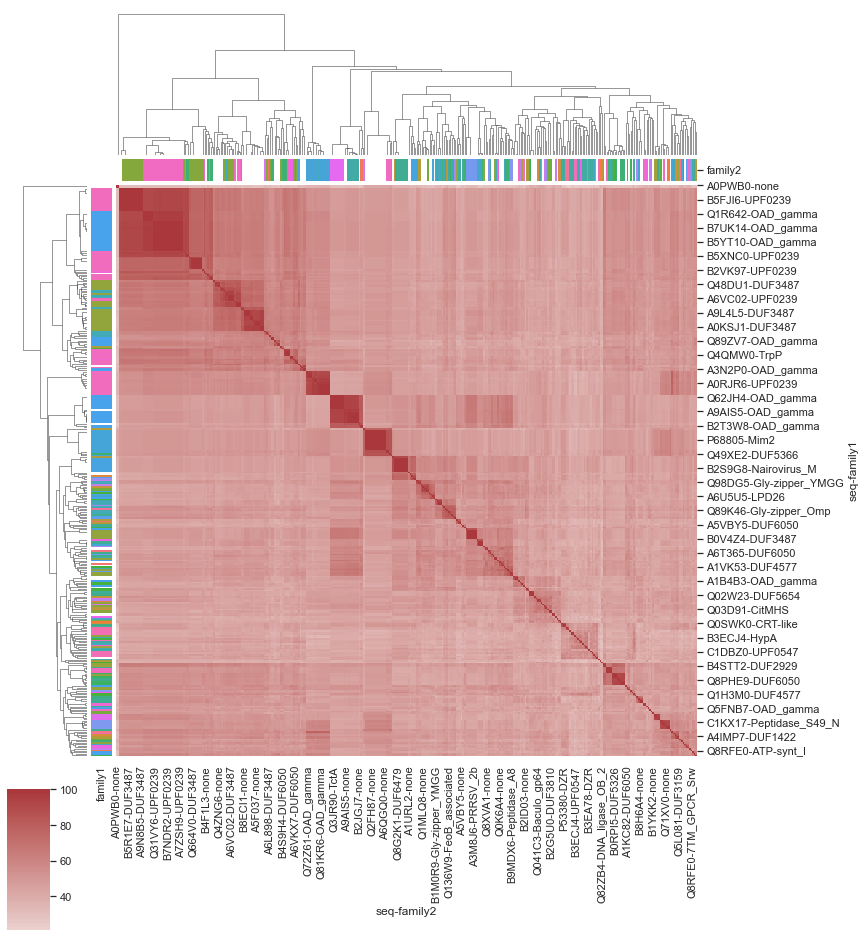

In [15]:
cluster_plot(id_matrix)

- Same, but for a much bigger cluster

In [41]:
d = load_all(PATH + "$$$/*.out", lim=10000, normalise=True)
d.head(5)

,phmm_eval,phmm_score,phmm_bias,reference,hmms_eval,hmms_score,hmms_bias,identity,nid,denom,seqlen,family,f_eval,f_score,f_bias,seq
A0A0I9QGZ7,1.700000e-266,1.000000,0.2,A0A0I9QGZ7,5.600000e-175,0.914144,0.1,NaN,NaN,NaN,379,Abhydrolase_1,0.0,72.6,0.2,NaN
A0A0I9QGZ7,1.700000e-266,1.000000,0.2,A0A0I9QGZ7,5.600000e-175,0.914144,0.1,NaN,NaN,NaN,379,Hydrolase_4,0.000068,22.3,0.0,NaN
A0A0I9QGZ7,1.700000e-266,1.000000,0.2,A0A0I9QGZ7,5.600000e-175,0.914144,0.1,NaN,NaN,NaN,379,Esterase,0.00033,20.5,0.0,NaN
A0A0I9QGZ7,1.700000e-266,1.000000,0.2,A0A0I9QGZ7,5.600000e-175,0.914144,0.1,NaN,NaN,NaN,379,Abhydrolase_6,0.00035,21.3,0.1,NaN
A0A0I9RJ56,2.400000e-68,0.066027,0.1,A0A0I9QGZ7,3.700000e-135,0.263524,0.0,34.05,126.0,370.0,370,Abhydrolase_1,0.0,55.8,0.1,NaN


In [58]:
p = d.sort_values(by=["hmms_score"], ascending=False).drop_duplicates(subset=["reference"], keep="first")
p

,phmm_eval,phmm_score,phmm_bias,reference,hmms_eval,hmms_score,hmms_bias,identity,nid,denom,seqlen,family,f_eval,f_score,f_bias,seq
B7M0A0,2.300000e-214,0.994913,0.4,Q83MH9,4.700000e-189,1.0,0.0,99.68,309.0,310.0,310,GHMP_kinases_C,0.0,46.0,0.0,NaN
A4GCL3,2.900000e-74,0.792135,4.6,P17043,1.900000e-81,1.0,6.3,95.87,116.0,121.0,121,CgtA,0.059,12.9,0.0,NaN
P03367,0.000000e+00,0.111818,22.8,Q74120,0.000000e+00,1.0,22.3,56.67,820.0,1447.0,1447,rve,0.0,55.5,0.0,NaN
C5FNU8,1.300000e-286,0.255082,12.7,B8XGR0,0.000000e+00,1.0,4.3,63.82,404.0,633.0,633,Peptidase_M36,0.0,541.0,6.7,NaN
P00350,3.800000e-301,0.914355,3.0,P37754,8.700000e-255,1.0,0.1,94.44,442.0,468.0,468,Glycos_trans_3N,0.011,15.6,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q47TK1,1.800000e-36,0.314540,0.2,Q9Z471,4.000000e-52,1.0,1.0,63.22,55.0,87.0,87,PRA-PH,0.0,45.7,0.9,NaN
Q9L9K3,4.900000e-208,0.944516,0.6,Q83PC5,1.400000e-157,1.0,0.1,95.25,301.0,316.0,316,AAA_18,0.18,12.5,0.0,NaN
Q88QR1,3.000000e-58,0.102116,0.1,A2RPN0,6.200000e-105,1.0,0.2,46.15,96.0,208.0,215,COQ7,0.0,150.6,0.9,NaN
B6YUL1,1.400000e-131,0.148790,5.7,O67275,5.900000e-203,1.0,9.5,53.25,213.0,400.0,405,SipA_VBS,0.099,12.8,0.4,NaN


,phmm_eval,phmm_score,phmm_bias,reference,hmms_eval,hmms_score,hmms_bias,identity,nid,denom,seqlen,family,f_eval,f_score,f_bias,seq
